# Reproducibility Notebook: Diabetes Dataset

This notebook demonstrates the complete counterfactual generation workflow for the diabetes dataset,
comparing DPG and DiCE methods without WandB logging.

## Workflow:
1. Load and prepare diabetes dataset
2. Train Random Forest classifier
3. Extract DPG constraints
4. Generate counterfactuals using both DPG and DiCE
5. Compute and compare metrics
6. Visualize results

In [26]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configure matplotlib for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Add parent directory to path
REPO_ROOT = Path.cwd().parent
sys.path.insert(0, str(REPO_ROOT))

# Set random seed for reproducibility
np.random.seed(42)

print(f"Repository root: {REPO_ROOT}")
print(f"Python version: {sys.version}")

Repository root: /home/rafaelgoncalves/gitgud/CounterFactualDPG
Python version: 3.10.12 (main, Jan  8 2026, 06:52:19) [GCC 11.4.0]


In [27]:
# Import project modules
from utils.dataset_loader import load_dataset
from utils.config_manager import load_config
from utils.replication_runner import run_counterfactual_generation
from ConstraintParser import ConstraintParser
from CounterFactualMetrics import evaluate_cf_list
from CounterFactualVisualizer import (
    plot_pca_with_counterfactuals_comparison,
    heatmap_techniques,
    plot_ridge_comparison
)
from DPG.dpg import plot_dpg_constraints_overview

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

print("✓ All imports successful")


✓ All imports successful


## 1. Load Dataset and Configuration

In [28]:
# Load diabetes dataset configuration
DATASET_NAME = 'diabetes'
config_path = REPO_ROOT / 'configs' / DATASET_NAME / 'config.yaml'

# Load unified config
config = load_config(str(config_path))

print(f"Loaded config for dataset: {DATASET_NAME}")
print(f"Model type: {config.model.type}") # type: ignore
print(f"Test size: {config.data.test_size}") # type: ignore
print(f"Random state: {config.data.random_state}") # type: ignore

INFO: Loaded base defaults from configs/config.yaml
INFO: No method specified, defaulting to 'dpg'
INFO: Using unified config with method 'dpg'
Loaded config for dataset: diabetes
Model type: RandomForestClassifier
Test size: 0.2
Random state: 42


In [29]:
# Load dataset
dataset_info = load_dataset(config, repo_root=REPO_ROOT)

FEATURES = dataset_info['features']
LABELS = dataset_info['labels']
FEATURE_NAMES = dataset_info['feature_names']
FEATURES_DF = dataset_info['features_df']

print(f"Dataset shape: {FEATURES.shape}")
print(f"Number of features: {len(FEATURE_NAMES)}")
print(f"Feature names: {FEATURE_NAMES}")
print(f"Class distribution: {np.bincount(LABELS)}")

# Display first few samples
print("\nFirst 5 samples:")
display(pd.DataFrame(FEATURES[:5], columns=FEATURE_NAMES))

INFO: Loading diabetes dataset...
INFO: Using separator: ','
INFO: Diabetes preprocessing - Removed 432 samples with zero values in features
INFO: Diabetes preprocessing - Kept 336 samples
INFO: Loaded 336 samples with 8 features
INFO: Classes: [0 1], distribution: [225 111]
Dataset shape: (336, 8)
Number of features: 8
Feature names: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Class distribution: [225 111]

First 5 samples:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
1,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0
2,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0
3,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0
4,5.0,166.0,72.0,19.0,175.0,25.8,0.587,51.0


## 2. Train Model

In [30]:
# Split data
TRAIN_FEATURES, TEST_FEATURES, TRAIN_LABELS, TEST_LABELS = train_test_split(
    FEATURES_DF,
    LABELS,
    test_size=config.data.test_size, # type: ignore
    random_state=config.data.random_state # type: ignore
)

print(f"Training samples: {len(TRAIN_FEATURES)}")
print(f"Test samples: {len(TEST_FEATURES)}")

Training samples: 268
Test samples: 68


In [31]:
# Train Random Forest model
model_config = config.model.to_dict() if hasattr(config.model, 'to_dict') else dict(config.model) # type: ignore
model_params = {k: v for k, v in model_config.items() if k != 'type' and v is not None}

model = RandomForestClassifier(**model_params)
model.fit(TRAIN_FEATURES, TRAIN_LABELS)

# Evaluate model
train_score = model.score(TRAIN_FEATURES, TRAIN_LABELS)
test_score = model.score(TEST_FEATURES, TEST_LABELS)

print("✓ Model trained successfully")
print(f"Train accuracy: {train_score:.4f}")
print(f"Test accuracy: {test_score:.4f}")

✓ Model trained successfully
Train accuracy: 0.8582
Test accuracy: 0.7794


## 3. Extract DPG Constraints

DPG initialized with perc_var=1e-07, decimal_threshold=3, n_jobs=-1

Starting DPG extraction *****************************************
Model Class: RandomForestClassifier
Model Class Module: sklearn.ensemble._forest
Model Estimators:  12
Model Params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 12, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
*****************************************************************


100%|██████████| 268/268 [00:03<00:00, 87.53it/s] 


Total of paths: 3216
Building DPG...


Processing cases: 100%|██████████| 3216/3216 [00:00<00:00, 10853.02it/s]


Extracting graph...
✓ DPG constraints extracted in 3.600s

Constraints summary:
  Number of classes: 2
  Class 0: 8 features with constraints
  Class 1: 8 features with constraints

DPG-LEARNED CONSTRAINTS (Normalized)

Class 0:
--------------------------------------------------------------------------------
  Age                            min:    28.50   max:    51.00
  BMI                            min:    26.35   max:    40.80
  BloodPressure                  min:    56.00   max:    85.50
  DiabetesPedigreeFunction       min:     0.26   max:     0.47
  Glucose                        min:   104.00   max:   155.50
  Insulin                        min:    85.50   max:   544.00
  Pregnancies                    min:     6.50   max:    12.50
  SkinThickness                  min:    17.50   max:    50.50

Class 1:
--------------------------------------------------------------------------------
  Age                            min:    24.50   max:    35.50
  BMI                           

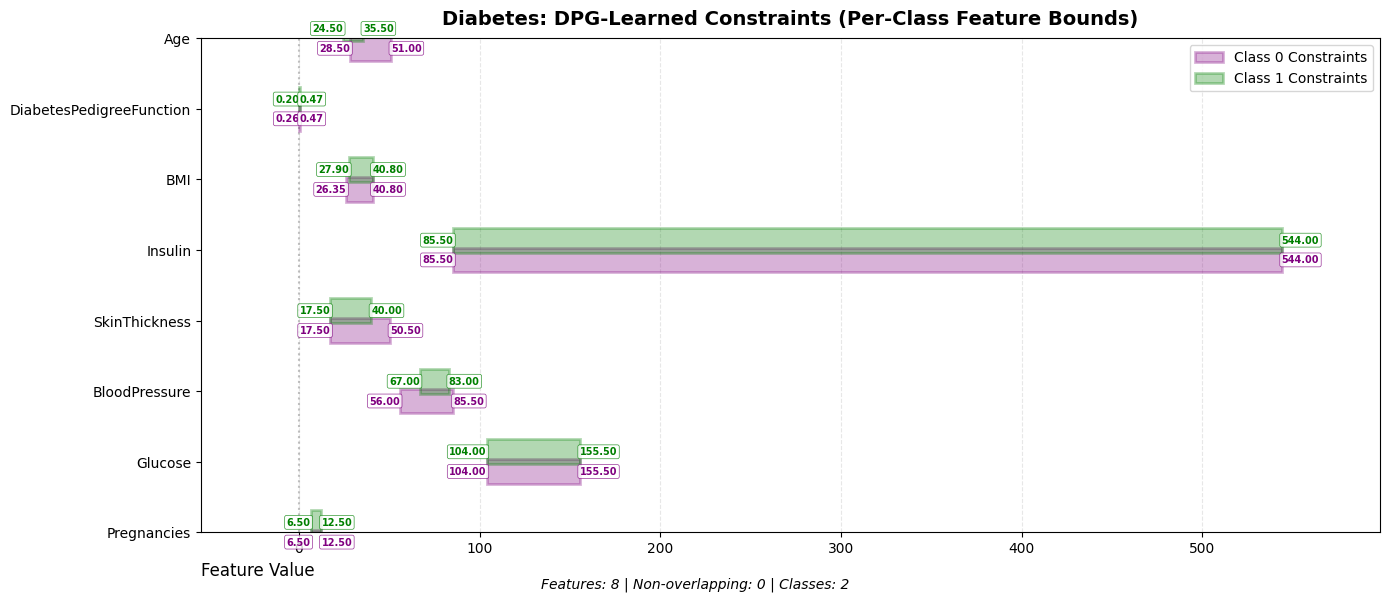

In [32]:
# Extract DPG constraints from training data
import time

start_time = time.perf_counter()

dpg_result = ConstraintParser.extract_constraints_from_dataset(
    model,
    TRAIN_FEATURES.values,
    TRAIN_LABELS,
    FEATURE_NAMES,
    dpg_config=None  # Use default DPG config
)

constraints = dpg_result['constraints']
normalized_constraints = ConstraintParser.normalize_constraints(constraints)

extraction_time = time.perf_counter() - start_time

print(f"✓ DPG constraints extracted in {extraction_time:.3f}s")

print("\nConstraints summary:")
print(f"  Number of classes: {len(normalized_constraints)}")
for class_name in sorted(normalized_constraints.keys()):
    print(f"  {class_name}: {len(normalized_constraints[class_name])} features with constraints")

# Display all constraints
print(f"\n{'='*80}")
print("DPG-LEARNED CONSTRAINTS (Normalized)")
print(f"{'='*80}")
for class_name in sorted(normalized_constraints.keys()):
    print(f"\n{class_name}:")
    print(f"{'-'*80}")
    for feat in sorted(normalized_constraints[class_name].keys()):
        bounds = normalized_constraints[class_name][feat]
        print(f"  {feat:30s} min: {bounds['min']:8.2f}   max: {bounds['max']:8.2f}")
print(f"{'='*80}")
print("Note: See visualizations below for graphical representation")
print(f"{'='*80}")

# Visualize constraints
fig = plot_dpg_constraints_overview(
    normalized_constraints=normalized_constraints,
    feature_names=FEATURE_NAMES,
    class_colors_list=['purple', 'green', 'orange'],
    title=f"{DATASET_NAME.title()}: DPG-Learned Constraints (Per-Class Feature Bounds)"
)
if fig:
    plt.tight_layout()
    plt.show()


## 4. Select Sample and Define Target

In [33]:
# Select a sample from training set for counterfactual generation
SAMPLE_INDEX = 2  # Use sample index from config (matching experiment)

original_sample_values = TRAIN_FEATURES.iloc[SAMPLE_INDEX].values
ORIGINAL_SAMPLE = dict(zip(FEATURE_NAMES, map(float, original_sample_values)))
SAMPLE_DATAFRAME = pd.DataFrame([ORIGINAL_SAMPLE])
ORIGINAL_CLASS = int(model.predict(SAMPLE_DATAFRAME)[0])

# Select target class (opposite of original)
unique_classes = np.unique(LABELS)
TARGET_CLASS = [c for c in unique_classes if c != ORIGINAL_CLASS][0]

print(f"Sample index: {SAMPLE_INDEX}")
print(f"Original class: {ORIGINAL_CLASS}")
print(f"Target class: {TARGET_CLASS}")
print("\nOriginal sample values:")
display(SAMPLE_DATAFRAME)


Sample index: 2
Original class: 0
Target class: 1

Original sample values:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,106.0,56.0,27.0,165.0,29.0,0.426,22.0


In [34]:
# Build actionability constraints from config
from utils.config_manager import build_dict_non_actionable

CONTINUOUS_INDICES = dataset_info.get('continuous_indices', list(range(len(FEATURE_NAMES))))
CATEGORICAL_INDICES = dataset_info.get('categorical_indices', [])
VARIABLE_INDICES = dataset_info.get('variable_indices', list(range(len(FEATURE_NAMES))))

dict_non_actionable = build_dict_non_actionable(config, FEATURE_NAMES, VARIABLE_INDICES)

print("Actionability constraints:")
frozen_features = [f for f, rule in dict_non_actionable.items() if rule == 'no_change']
directional_features = {f: rule for f, rule in dict_non_actionable.items() 
                       if rule in ['non_increasing', 'non_decreasing']}

if frozen_features:
    print(f"  Frozen features: {frozen_features}")
if directional_features:
    print(f"  Directional constraints: {directional_features}")
if not frozen_features and not directional_features:
    print("  All features actionable")

Actionability constraints:
  Frozen features: ['DiabetesPedigreeFunction']
  Directional constraints: {'Pregnancies': 'non_decreasing', 'Age': 'non_decreasing'}


## 5. Generate Counterfactuals - DPG Method

In [35]:
# Configure for DPG method
import random
import time

# Set random seeds for reproducibility (matching experiment seed)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

config_dpg = config.to_dict()
config_dpg['counterfactual']['method'] = 'dpg'

# Prepare training data for DiCE (not used for DPG but required by interface)
train_df_for_dice = TRAIN_FEATURES.copy()
train_df_for_dice['_target_'] = TRAIN_LABELS

# Generate DPG counterfactuals
NUM_CFS = 5
config_dpg['experiment_params']['requested_counterfactuals'] = NUM_CFS

generation_args_dpg = (
    ORIGINAL_SAMPLE,
    TARGET_CLASS,
    FEATURE_NAMES,
    dict_non_actionable,
    config_dpg,
    model,
    constraints,
    train_df_for_dice,
    CONTINUOUS_INDICES,
    CATEGORICAL_INDICES
)

print(f"Generating {NUM_CFS} counterfactuals using DPG (seed={SEED})...")
start_time = time.perf_counter()
result_dpg = run_counterfactual_generation(generation_args_dpg)
dpg_runtime = time.perf_counter() - start_time

print(f"✓ DPG generation completed in {dpg_runtime:.3f}s")


Generating 5 counterfactuals using DPG (seed=42)...
DEBUG counterfactual_runner: Generated 5 counterfactuals, best_fitness_list length = 1, avg_fitness_list length = 1, evolution_history length = 1
✓ DPG generation completed in 0.693s


In [36]:
# Extract DPG counterfactuals
dpg_counterfactuals = result_dpg.get('all_counterfactuals', []) # type: ignore
dpg_cf_df = pd.DataFrame(dpg_counterfactuals)
dpg_predictions = model.predict(dpg_cf_df) if len(dpg_counterfactuals) > 0 else []

# Count valid (matching target class)
dpg_valid = sum(1 for pred in dpg_predictions if pred == TARGET_CLASS)

print("DPG Results:")
print(f"  Generated: {len(dpg_counterfactuals)} counterfactuals")
print(f"  Valid (target class): {dpg_valid}/{len(dpg_counterfactuals)}")
print(f"  Success rate: {dpg_valid/NUM_CFS*100:.1f}%")

if len(dpg_counterfactuals) > 0:
    print("\nFirst DPG counterfactual:")
    display(pd.DataFrame([dpg_counterfactuals[0]]))

DPG Results:
  Generated: 5 counterfactuals
  Valid (target class): 5/5
  Success rate: 100.0%

First DPG counterfactual:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.3025,155.49786,56.40901,26.83467,151.67021,29.18034,0.426,22.37799


## 6. Generate Counterfactuals - DiCE Method

In [37]:
# Configure for DiCE method
# Set random seeds for reproducibility
np.random.seed(SEED)
random.seed(SEED)

config_dice = config.to_dict()
config_dice['counterfactual']['method'] = 'dice'
config_dice['experiment_params']['requested_counterfactuals'] = NUM_CFS

generation_args_dice = (
    ORIGINAL_SAMPLE,
    TARGET_CLASS,
    FEATURE_NAMES,
    dict_non_actionable,
    config_dice,
    model,
    constraints,
    train_df_for_dice,
    CONTINUOUS_INDICES,
    CATEGORICAL_INDICES
)

print(f"Generating {NUM_CFS} counterfactuals using DiCE (seed={SEED})...")
start_time = time.perf_counter()
result_dice = run_counterfactual_generation(generation_args_dice)
dice_runtime = time.perf_counter() - start_time

print(f"✓ DiCE generation completed in {dice_runtime:.3f}s")


Generating 5 counterfactuals using DiCE (seed=42)...
INFO: Applying directional actionability constraints as permitted_range: {'Pregnancies': [2.0, 17.0], 'Age': [22.0, 81.0]}


100%|██████████| 1/1 [00:00<00:00, 13.92it/s]

DEBUG counterfactual_runner: DiCE generated 5 counterfactuals
✓ DiCE generation completed in 0.103s


In [38]:
# Extract DiCE counterfactuals
dice_counterfactuals = result_dice.get('all_counterfactuals', [])
dice_cf_df = pd.DataFrame(dice_counterfactuals)
dice_predictions = model.predict(dice_cf_df) if len(dice_counterfactuals) > 0 else []

# Count valid
dice_valid = sum(1 for pred in dice_predictions if pred == TARGET_CLASS)

print("DiCE Results:")
print(f"  Generated: {len(dice_counterfactuals)} counterfactuals")
print(f"  Valid (target class): {dice_valid}/{len(dice_counterfactuals)}")
print(f"  Success rate: {dice_valid/NUM_CFS*100:.1f}%")

if len(dice_counterfactuals) > 0:
    print("\nFirst DiCE counterfactual:")
    display(pd.DataFrame([dice_counterfactuals[0]]))

DiCE Results:
  Generated: 5 counterfactuals
  Valid (target class): 5/5
  Success rate: 100.0%

First DiCE counterfactual:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2.0,146.0,76.0,35.0,194.0,38.2,0.426,29.0


## 7. Compute and Compare Metrics

In [39]:
# Compute comprehensive metrics for both methods
x_original = np.array([ORIGINAL_SAMPLE[feat] for feat in FEATURE_NAMES])
X_train = TRAIN_FEATURES.values
X_test = TEST_FEATURES.values

# DPG metrics
if len(dpg_counterfactuals) > 0:
    dpg_cf_array = np.array([[cf[feat] for feat in FEATURE_NAMES] for cf in dpg_counterfactuals])
    dpg_metrics = evaluate_cf_list(
        cf_list=dpg_cf_array,  # Pass numpy array directly, not list
        x=x_original,
        model=model,
        y_val=ORIGINAL_CLASS,
        max_nbr_cf=NUM_CFS,
        variable_features=VARIABLE_INDICES,
        continuous_features_all=CONTINUOUS_INDICES,
        categorical_features_all=CATEGORICAL_INDICES,
        X_train=X_train,
        X_test=X_test,
        ratio_cont=len(CONTINUOUS_INDICES)/len(FEATURE_NAMES),
        nbr_features=len(FEATURE_NAMES)
    )
else:
    dpg_metrics = {}

# DiCE metrics
if len(dice_counterfactuals) > 0:
    dice_cf_array = np.array([[cf[feat] for feat in FEATURE_NAMES] for cf in dice_counterfactuals])
    dice_metrics = evaluate_cf_list(
        cf_list=dice_cf_array,  # Pass numpy array directly, not list
        x=x_original,
        model=model,
        y_val=ORIGINAL_CLASS,
        max_nbr_cf=NUM_CFS,
        variable_features=VARIABLE_INDICES,
        continuous_features_all=CONTINUOUS_INDICES,
        categorical_features_all=CATEGORICAL_INDICES,
        X_train=X_train,
        X_test=X_test,
        ratio_cont=len(CONTINUOUS_INDICES)/len(FEATURE_NAMES),
        nbr_features=len(FEATURE_NAMES)
    )
else:
    dice_metrics = {}

print("✓ Metrics computed for both methods")

✓ Metrics computed for both methods


In [40]:
# Create comparison table
key_metrics = [
    'perc_valid_cf_all',
    'perc_actionable_cf_all',
    'plausibility_nbr_cf',
    'distance_mh',
    'avg_nbr_changes',
    'count_diversity_all',
    'accuracy_knn_sklearn'
]

comparison_data = []
for metric in key_metrics:
    dpg_val = dpg_metrics.get(metric, 'N/A')
    dice_val = dice_metrics.get(metric, 'N/A')
    
    # Format values
    if dpg_val != 'N/A':
        dpg_val = f"{dpg_val:.4f}" if isinstance(dpg_val, (int, float)) else dpg_val
    if dice_val != 'N/A':
        dice_val = f"{dice_val:.4f}" if isinstance(dice_val, (int, float)) else dice_val
    
    comparison_data.append({
        'Metric': metric,
        'DPG': dpg_val,
        'DiCE': dice_val
    })

# Add runtime
comparison_data.append({
    'Metric': 'runtime',
    'DPG': f"{dpg_runtime:.3f}s",
    'DiCE': f"{dice_runtime:.3f}s"
})

comparison_df = pd.DataFrame(comparison_data)
print("\nMetrics Comparison:")
display(comparison_df)


Metrics Comparison:


,Metric,DPG,DiCE
0,perc_valid_cf_all,1.0000,1.0000
1,perc_actionable_cf_all,1.0000,1.0000
2,plausibility_nbr_cf,6.3803,6.3816
3,distance_mh,3.2105,9.4635
4,avg_nbr_changes,0.6750,0.7250
5,count_diversity_all,0.2950,0.2600
6,accuracy_knn_sklearn,1.0000,1.0000
7,runtime,0.693s,0.103s


## 8. Visualizations

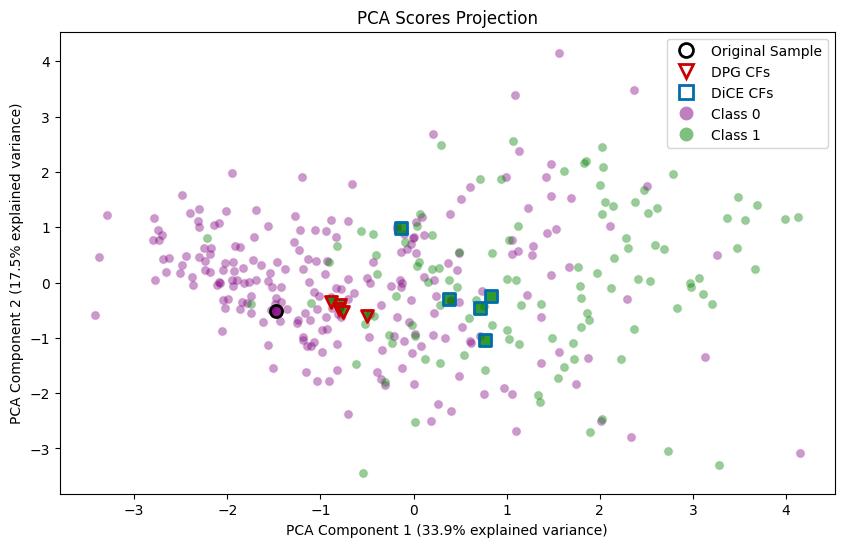

In [41]:
# PCA Comparison Plot
if len(dpg_counterfactuals) > 0 and len(dice_counterfactuals) > 0:
    from IPython.display import Image, display
    import io
    
    # Prepare DataFrames and predictions
    dpg_cf_df_viz = pd.DataFrame(dpg_counterfactuals)
    dice_cf_df_viz = pd.DataFrame(dice_counterfactuals)
    dpg_preds_viz = model.predict(dpg_cf_df_viz)
    dice_preds_viz = model.predict(dice_cf_df_viz)
    
    fig = plot_pca_with_counterfactuals_comparison(
        model=model,
        dataset=FEATURES_DF,
        target=LABELS,
        sample=ORIGINAL_SAMPLE,
        counterfactuals_df_1=dpg_cf_df_viz,
        cf_predicted_classes_1=dpg_preds_viz,
        counterfactuals_df_2=dice_cf_df_viz,
        cf_predicted_classes_2=dice_preds_viz,
        method_1_name='DPG',
        method_2_name='DiCE',
        method_1_color="#CC0000",
        method_2_color="#006DAC"
    )
    
    # Save to BytesIO and display (figures are closed by the function)
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    display(Image(buf.read()))
    buf.close()
else:
    print("Insufficient counterfactuals for PCA plot")

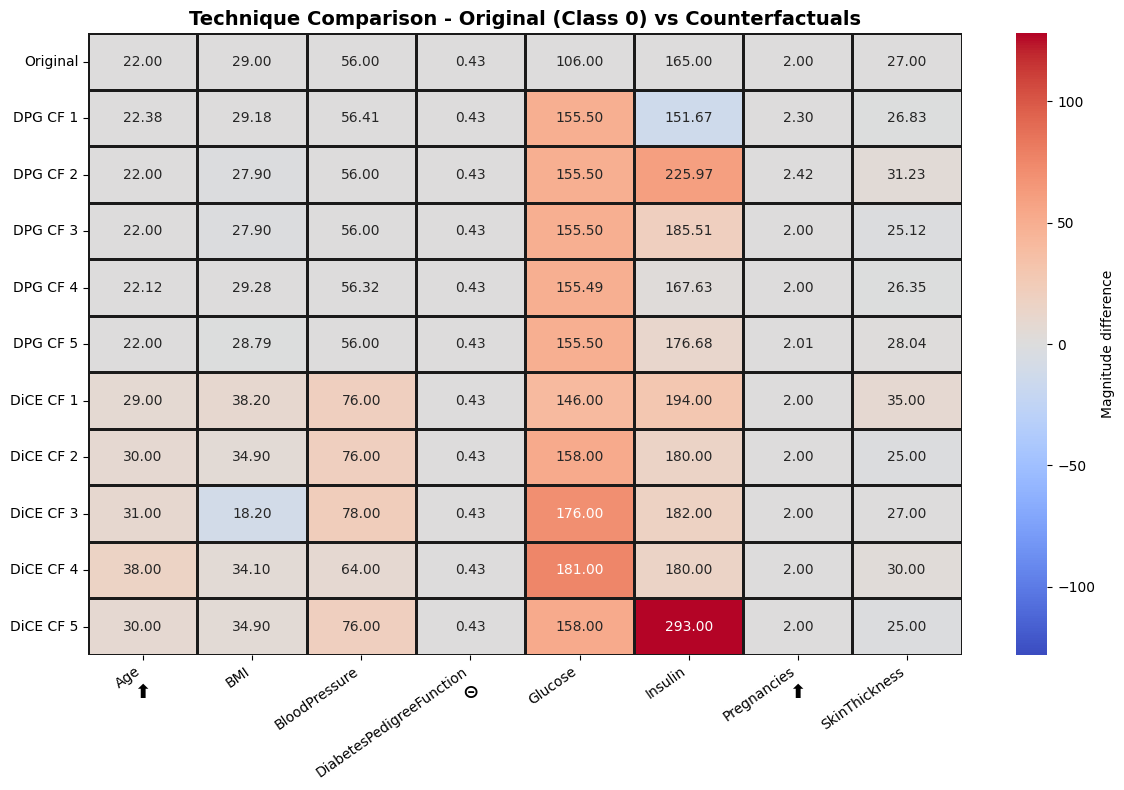

In [42]:
# Feature Heatmap Comparison
if len(dpg_counterfactuals) > 0 and len(dice_counterfactuals) > 0:
    from IPython.display import Image, display
    import io
    
    # Take first 5 counterfactuals from each method
    n_display = min(5, len(dpg_counterfactuals), len(dice_counterfactuals))
    
    fig = heatmap_techniques(
        sample=ORIGINAL_SAMPLE,
        class_sample=ORIGINAL_CLASS,
        cf_list_1=dpg_counterfactuals[:n_display],
        cf_list_2=dice_counterfactuals[:n_display],
        technique_names=('DPG', 'DiCE'),
        restrictions=dict_non_actionable
    )
    
    # Save to BytesIO and display
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    display(Image(buf.read()))
    buf.close()
else:
    print("Insufficient counterfactuals for heatmap")

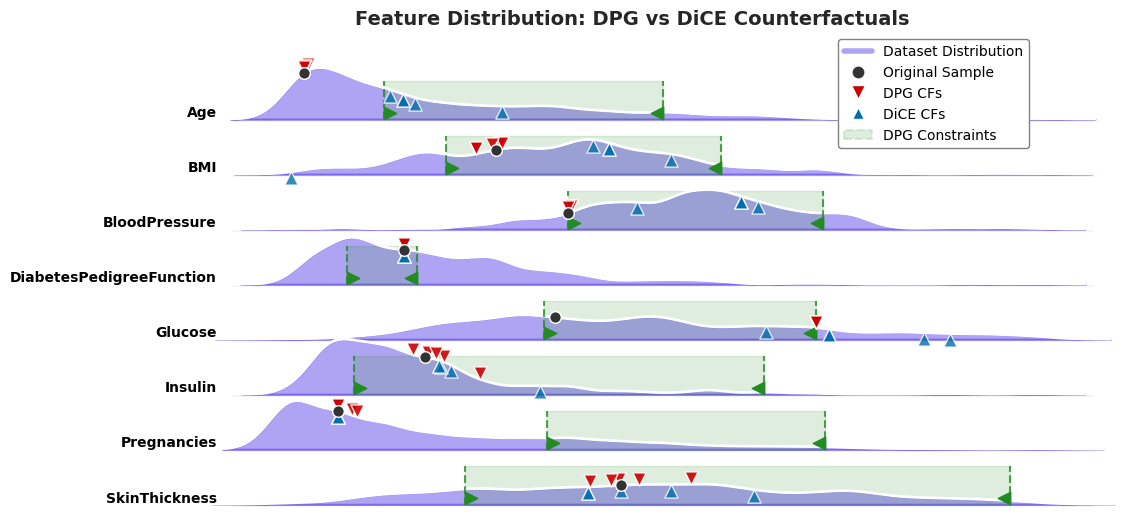

In [43]:
# Ridge Plot - Feature Distribution Comparison
if len(dpg_counterfactuals) >= 2 and len(dice_counterfactuals) >= 2:
    from IPython.display import Image, display
    import io
    
    try:
        fig = plot_ridge_comparison(
            sample=ORIGINAL_SAMPLE,
            cf_list_1=dpg_counterfactuals,
            cf_list_2=dice_counterfactuals,
            technique_names=('DPG', 'DiCE'),
            method_1_color="#CC0000",  # Orange for DPG (matching PCA visualization)
            method_2_color="#006DAC",  # Blue for DiCE (matching PCA visualization)
            dataset_df=FEATURES_DF,
            constraints=normalized_constraints  # DPG-learned constraints
        )
        
        # Save to BytesIO and display
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        display(Image(buf.read()))
        buf.close()
    except Exception as e:
        print(f"Could not create ridge plot: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Need at least 2 counterfactuals from each method for ridge plot")


### DPG Constraints Visualization

This plot shows the DPG-learned constraints (min/max bounds per feature per class) with the original sample and first counterfactuals from both methods overlaid.

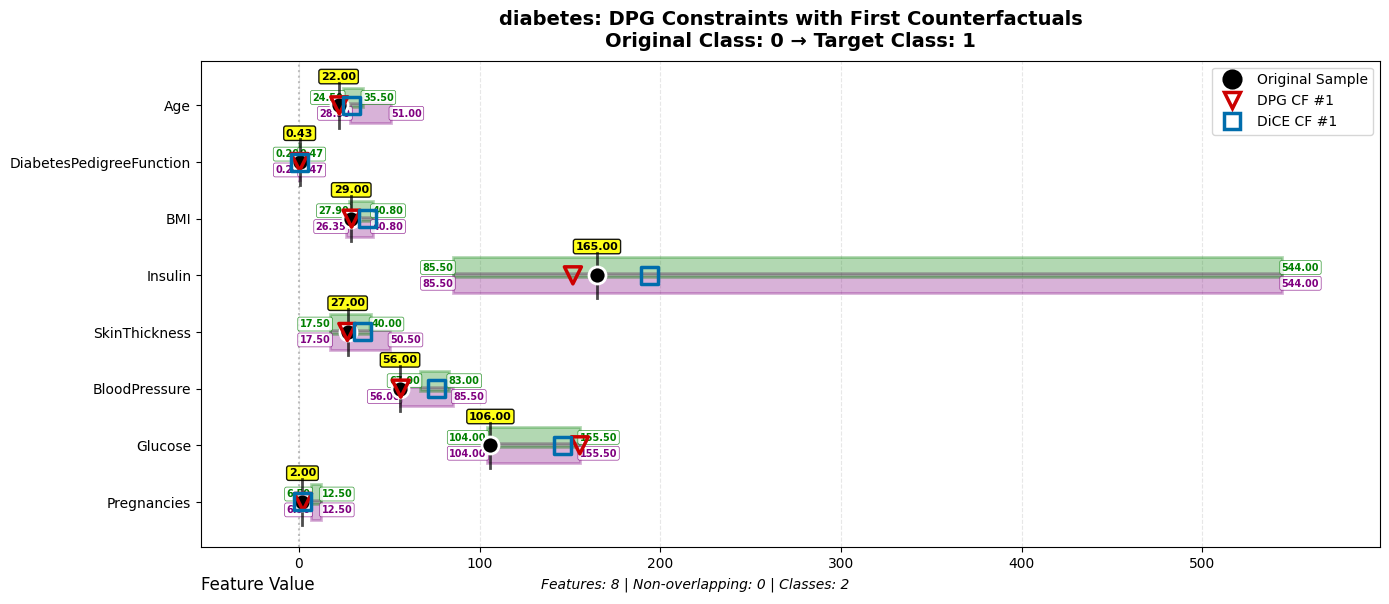

In [44]:
# DPG Constraints Overview with Counterfactuals
if len(dpg_counterfactuals) > 0 and len(dice_counterfactuals) > 0:
    from IPython.display import Image, display
    import io
    from DPG.dpg import plot_dpg_constraints_overview
    from matplotlib.lines import Line2D
    
    try:
        # Get first CF from each method
        dpg_first_cf = dpg_counterfactuals[0]
        dice_first_cf = dice_counterfactuals[0]
        
        # Define class colors
        class_colors_list = ['purple', 'green', 'orange']
        
        # Create base constraints plot
        fig = plot_dpg_constraints_overview(
            normalized_constraints=normalized_constraints,
            feature_names=FEATURE_NAMES,
            class_colors_list=class_colors_list,
            original_sample=ORIGINAL_SAMPLE,
            original_class=ORIGINAL_CLASS,
            target_class=TARGET_CLASS,
            title=f"{DATASET_NAME}: DPG Constraints with First Counterfactuals"
        )
        
        if fig is None:
            print("Could not create constraints visualization")
        else:
            # Get the axis from the figure
            ax = fig.axes[0]
            
            # Get features with constraints and their y positions
            features_with_constraints = []
            for feat in FEATURE_NAMES:
                has_constraint = any(
                    feat in normalized_constraints.get(cname, {})
                    for cname in normalized_constraints.keys()
                )
                if has_constraint:
                    features_with_constraints.append(feat)
            
            n_features = len(features_with_constraints)
            y_positions = np.arange(n_features)
            feature_to_y = {feat: y_positions[i] for i, feat in enumerate(features_with_constraints)}
            
            # Define colors matching PCA comparison
            dpg_color = "#CC0000"  # Red/Orange for DPG
            dice_color = "#006DAC"  # Blue for DiCE
            marker_size = 150
            linewidth = 2.5
            
            # Overlay DPG counterfactual markers (triangle down)
            for feat in features_with_constraints:
                if feat in dpg_first_cf and feat in feature_to_y:
                    y = feature_to_y[feat]
                    x = dpg_first_cf[feat]
                    ax.scatter(x, y, marker='v', s=marker_size,
                              edgecolor=dpg_color, facecolor='none',
                              linewidths=linewidth, zorder=10)
            
            # Overlay DiCE counterfactual markers (square)
            for feat in features_with_constraints:
                if feat in dice_first_cf and feat in feature_to_y:
                    y = feature_to_y[feat]
                    x = dice_first_cf[feat]
                    ax.scatter(x, y, marker='s', s=marker_size,
                              edgecolor=dice_color, facecolor='none',
                              linewidths=linewidth, zorder=10)
            
            # Add enhanced legend
            legend_elements = [
                Line2D([0], [0], marker='o', color='w',
                       markerfacecolor='black', markersize=12,
                       markeredgecolor='black', markeredgewidth=linewidth,
                       label='Original Sample'),
                Line2D([0], [0], marker='v', color='w',
                       markerfacecolor='none', markersize=12,
                       markeredgecolor=dpg_color, markeredgewidth=linewidth,
                       label='DPG CF #1'),
                Line2D([0], [0], marker='s', color='w',
                       markerfacecolor='none', markersize=12,
                       markeredgecolor=dice_color, markeredgewidth=linewidth,
                       label='DiCE CF #1')
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
            
            # Display the figure
            buf = io.BytesIO()
            fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
            buf.seek(0)
            display(Image(buf.read()))
            buf.close()
            plt.close(fig)
            
    except Exception as e:
        print(f"Could not create constraints visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Insufficient counterfactuals for constraints visualization")

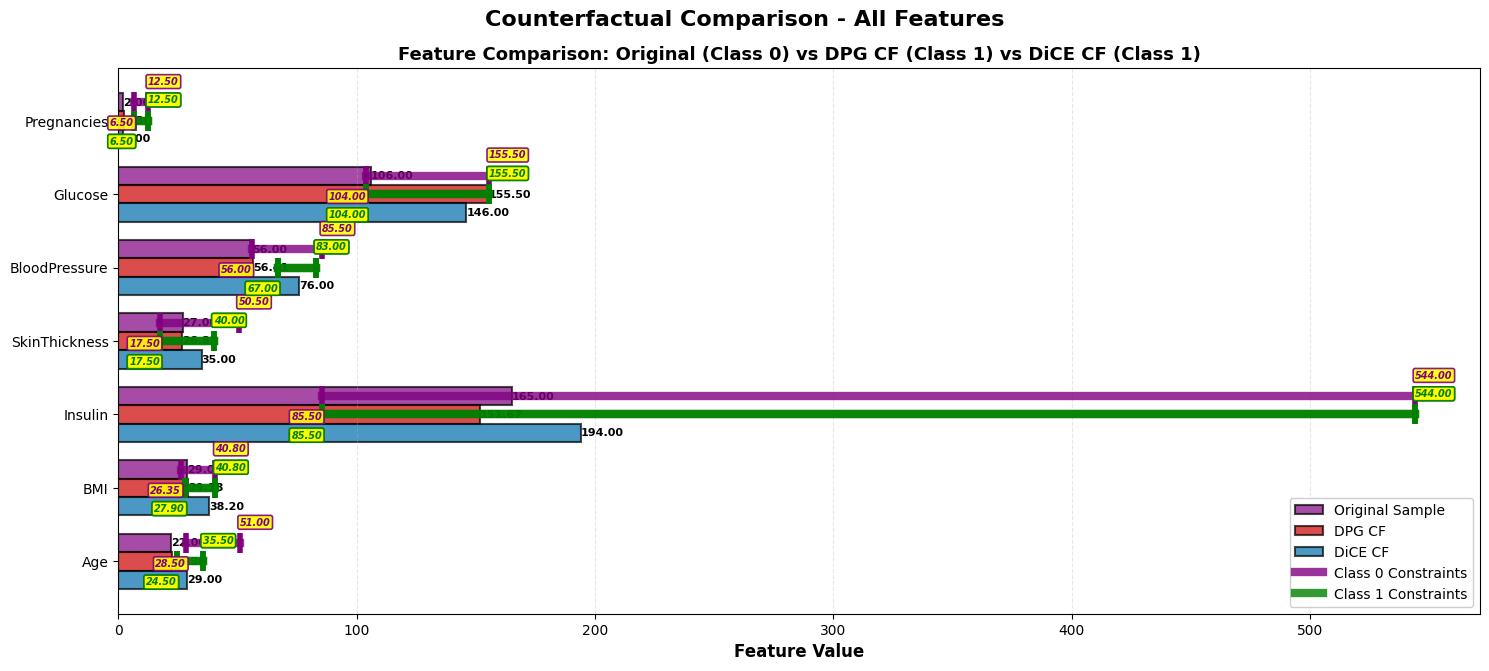

In [45]:
# Individual Counterfactual Comparison (first CF from each method)
from CounterFactualVisualizer import plot_sample_and_counterfactual_comparison_combined


if len(dpg_counterfactuals) > 0 and len(dice_counterfactuals) > 0:
    from IPython.display import Image, display
    import io
    
    sample_df = pd.DataFrame([ORIGINAL_SAMPLE])
    
    try:
        fig = plot_sample_and_counterfactual_comparison_combined(
            model=model,
            sample=ORIGINAL_SAMPLE,
            sample_df=sample_df,
            dpg_cf=dpg_counterfactuals[0],
            dice_cf=dice_counterfactuals[0],
            method_names=('DPG', 'DiCE'),
            constraints=normalized_constraints,
            restrictions=dict_non_actionable
        )
        
        # Save to BytesIO and display
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        display(Image(buf.read()))
        buf.close()
    except Exception as e:
        print(f"Could not create combined comparison plot: {e}")
else:
    print("Insufficient counterfactuals for individual comparison")

## 9. Summary of Results

In [ ]:
# Final summary statistics 
print("="*60)
print("REPRODUCIBILITY SUMMARY")
print("="*60)
print(f"Dataset: {DATASET_NAME}")
print(f"Sample index: {SAMPLE_INDEX}")
print(f"Original class: {ORIGINAL_CLASS} → Target class: {TARGET_CLASS}")
print("\nModel Performance:")
print(f"  Train accuracy: {train_score:.4f}")
print(f"  Test accuracy: {test_score:.4f}")
print("\nDPG Results:")
print(f"  Valid CFs: {dpg_valid}/{NUM_CFS} ({dpg_valid/NUM_CFS*100:.1f}%)")
print(f"  Runtime: {dpg_runtime:.3f}s")
print("\nDiCE Results:")
print(f"  Valid CFs: {dice_valid}/{NUM_CFS} ({dice_valid/NUM_CFS*100:.1f}%)")
print(f"  Runtime: {dice_runtime:.3f}s")
print("="*60)

REPRODUCIBILITY SUMMARY
Dataset: diabetes
Sample index: 2
Original class: 0 → Target class: 1

Model Performance:
  Train accuracy: 0.8582
  Test accuracy: 0.7794

DPG Results:
  Valid CFs: 5/5 (100.0%)
  Runtime: 0.693s

DiCE Results:
  Valid CFs: 5/5 (100.0%)
  Runtime: 0.103s
